In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Define constants
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
NUM_EPOCHS = 100

fruit_classes = ['dragonfruit', 'durian', 'grape', 'strawberry']

In [4]:
# Paths for the ripe and unripe fruits
ripe_dragon_fruit = '/kaggle/input/fruit-ripeness-classification/Ripe Dragon Fruit'
ripe_durian = '/kaggle/input/fruit-ripeness-classification/Ripe Durian'
ripe_grape = '/kaggle/input/fruit-ripeness-classification/Ripe Grape'
ripe_strawberry = '/kaggle/input/fruit-ripeness-classification/Ripe Strawberry'

unripe_dragon_fruit = '/kaggle/input/fruit-ripeness-classification/Unripe Dragon Fruit'
unripe_durian = '/kaggle/input/fruit-ripeness-classification/Unripe Durian'
unripe_grape = '/kaggle/input/fruit-ripeness-classification/Unripe Grape'
unripe_strawberry = '/kaggle/input/fruit-ripeness-classification/Unripe Strawberry'

# Initialize empty lists for images and labels
images = []
labels = []

# Create a dictionary to map fruit names to numeric labels
fruit_to_label = {
    'dragon fruit': 0,
    'durian': 1,
    'grape': 2,
    'strawberry': 3,
}

# Function to read images, resize them, and label them using TensorFlow Keras
def load_images_from_folder(folder, label):
    numeric_label = fruit_to_label[label]  # Convert label to number
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith(('.jpg', '.jpeg', '.png')):  # Check for image files
            try:
                # Read image using TensorFlow Keras
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
                img_array = tf.keras.preprocessing.image.img_to_array(img)  # Convert image to numpy array
                images.append(img_array)  # Append the image array
                labels.append(numeric_label)  # Append the numeric label
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

# Load images for each fruit (combine ripe and unripe)
load_images_from_folder(ripe_dragon_fruit, 'dragon fruit')
load_images_from_folder(unripe_dragon_fruit, 'dragon fruit')

load_images_from_folder(ripe_durian, 'durian')
load_images_from_folder(unripe_durian, 'durian')

load_images_from_folder(ripe_grape, 'grape')
load_images_from_folder(unripe_grape, 'grape')

load_images_from_folder(ripe_strawberry, 'strawberry')
load_images_from_folder(unripe_strawberry, 'strawberry')

# Count the number of images labeled as each fruit using np.count_nonzero
dragon_fruit_count = np.count_nonzero(np.array(labels) == fruit_to_label['dragon fruit'])
durian_count = np.count_nonzero(np.array(labels) == fruit_to_label['durian'])
grape_count = np.count_nonzero(np.array(labels) == fruit_to_label['grape'])
strawberry_count = np.count_nonzero(np.array(labels) == fruit_to_label['strawberry'])

# Print the counts for each fruit
print(f"Number of images labeled as 'dragon fruit': {dragon_fruit_count}")
print(f"Number of images labeled as 'durian': {durian_count}")
print(f"Number of images labeled as 'grape': {grape_count}")
print(f"Number of images labeled as 'strawberry': {strawberry_count}")

# Verify the length of images and labels lists
print(f"Total number of images: {len(images)}")
print(f"Total number of labels: {len(labels)}")

Number of images labeled as 'dragon fruit': 2127
Number of images labeled as 'durian': 1626
Number of images labeled as 'grape': 1675
Number of images labeled as 'strawberry': 1434
Total number of images: 6862
Total number of labels: 6862


In [5]:
# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the images
images = images / 255.0  # Scale pixel values to [0, 1]

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Create data generators for training and validation
train_datagen = ImageDataGenerator(rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

val_datagen = ImageDataGenerator()  # No augmentation for validation

In [6]:
print(f"Number of training images: {len(X_train)}")
print(f"Number of validation images: {len(X_val)}")
print(f"Number of test images: {len(X_test)}")

Number of training images: 4803
Number of validation images: 1029
Number of test images: 1030


In [7]:
# Fit the model
model = models.Sequential([
    # Convolutional Layers
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the output of the last convolutional layer
    layers.Flatten(),
    
    # Fully Connected (Dense) Layers
    layers.Dense(512, activation='relu'),  # Larger dense layer for feature learning
    layers.Dropout(0.5),                   # Dropout for regularization
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),                   # Dropout for further regularization
    
    # Output Layer
    layers.Dense(len(fruit_classes), activation='softmax')  # Softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,909,892 (33.99 MB)

 Trainable params: 8,909,892 (33.99 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Fit the model using the data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val)

# Define EarlyStopping with patience of 3
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               verbose=1,
                               restore_best_weights=True)

# Train the model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=NUM_EPOCHS,  # Change the number of epochs as needed
                    verbose=1,
                    # callbacks=[early_stopping]
                   )

Epoch 1/100


I0000 00:00:1733990319.929115      89 service.cc:145] XLA service 0x7eaf080059e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733990319.929196      89 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/151 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.2639 - loss: 1.4836 

I0000 00:00:1733990325.572022      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


151/151 ━━━━━━━━━━━━━━━━━━━━ 28s 129ms/step - accuracy: 0.4068 - loss: 1.1895 - val_accuracy: 0.7493 - val_loss: 0.7419
Epoch 2/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.7144 - loss: 0.7041 - val_accuracy: 0.8474 - val_loss: 0.4089
Epoch 3/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - accuracy: 0.8259 - loss: 0.4792 - val_accuracy: 0.8290 - val_loss: 0.6900
Epoch 4/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.8309 - loss: 0.4858 - val_accuracy: 0.9116 - val_loss: 0.3179
Epoch 5/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - accuracy: 0.8916 - loss: 0.3278 - val_accuracy: 0.9281 - val_loss: 0.2146
Epoch 6/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.8922 - loss: 0.3048 - val_accuracy: 0.9281 - val_loss: 0.2150
Epoch 7/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.9143 - loss: 0.2420 - val_accuracy: 0.9320 - val_loss: 0.2021
Epoch 8/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.8928 - loss: 0.319

In [9]:
# Evaluate the model on the test set
test_generator = val_datagen.flow(X_test, y_test)
test_loss, test_acc = model.evaluate(test_generator)

print(f'Test Accuracy: {test_acc:.2f}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9803 - loss: 0.0712
Test Accuracy: 0.98


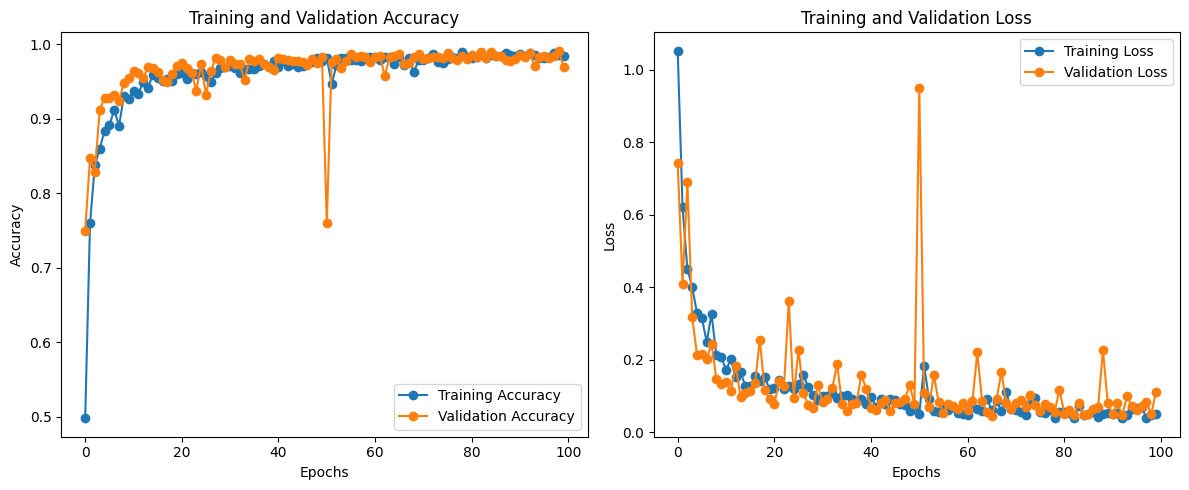

In [10]:
import matplotlib.pyplot as plt

# Extract the history dictionary
history_dict = history.history

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss', marker='o')
plt.plot(history_dict['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


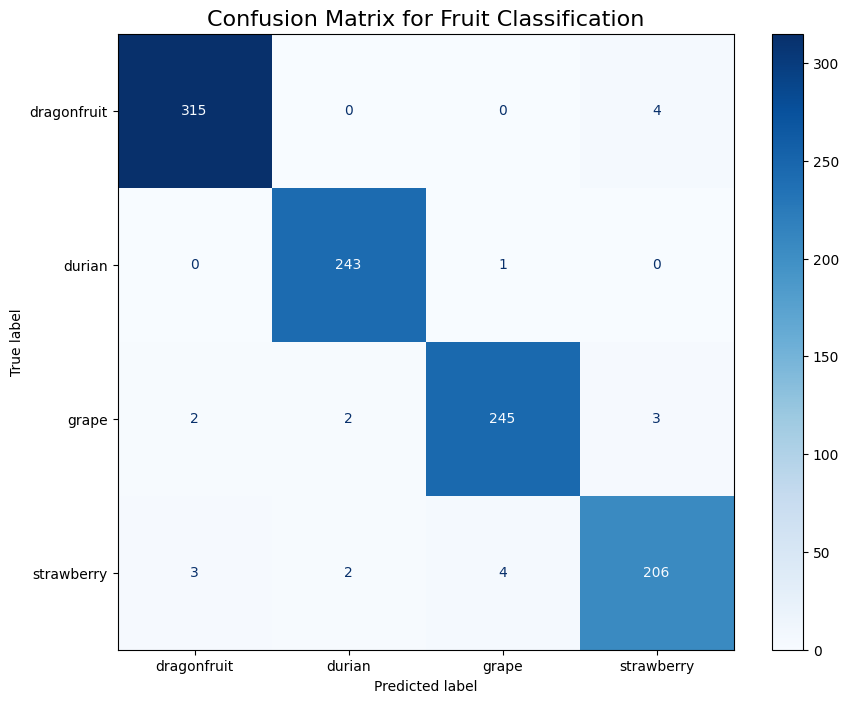

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Generate predictions on the test set
y_pred_probs = model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=fruit_classes)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', ax=ax)

# Add a title
ax.set_title("Confusion Matrix for Fruit Classification", fontsize=16)

# Show the plot
plt.show()

In [12]:
# Save the model to /kaggle/working directory
model.save('/kaggle/working/fruit_classification_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


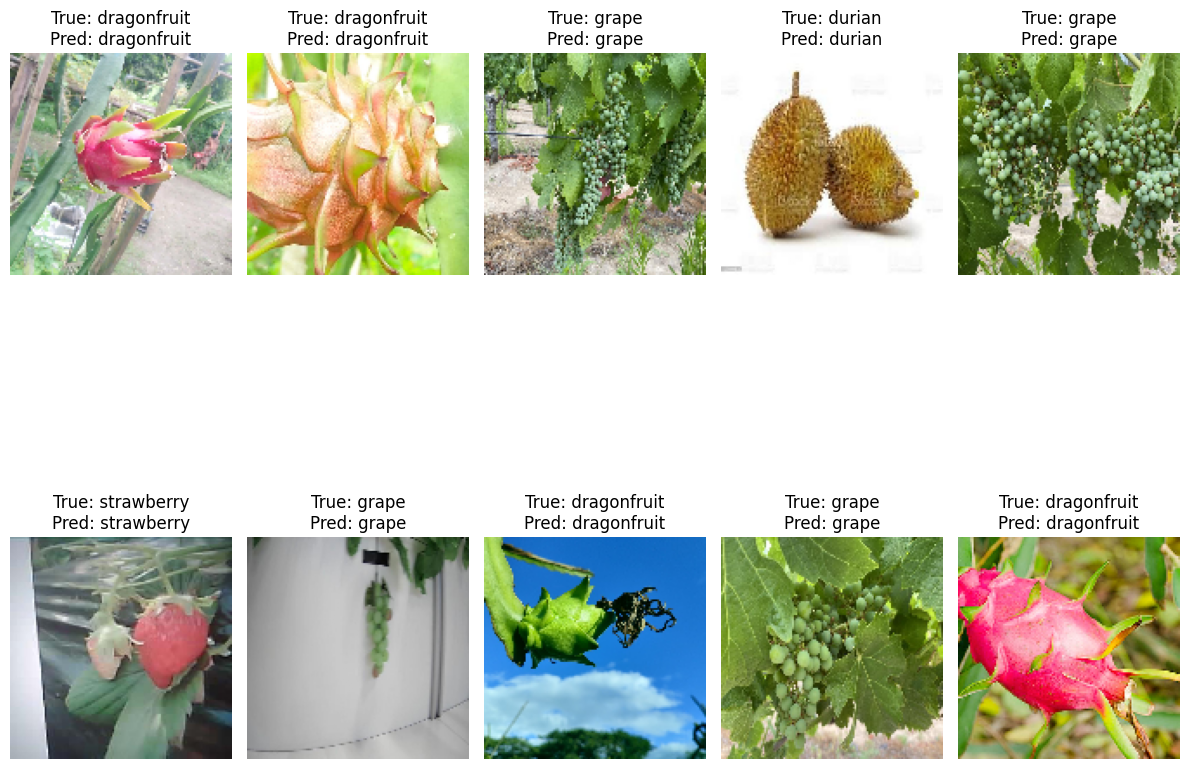

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Pick 10 random indices from the test set
random_indices = np.random.choice(len(X_test), size=10, replace=False)

# Get the images and corresponding true labels
random_images = X_test[random_indices]
random_labels = y_test[random_indices]

# Predict the labels using the trained model
predictions = model.predict(random_images)

# Get the class labels (fruit names) based on the predicted class indices
predicted_labels = np.argmax(predictions, axis=1)

# Map the class indices back to the fruit names
predicted_labels_names = [fruit_classes[label] for label in predicted_labels]
true_labels_names = [fruit_classes[label] for label in random_labels]

# Plot the images and show the predicted and true labels
plt.figure(figsize=(12, 12))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_images[i])
    plt.title(f"True: {true_labels_names[i]}\nPred: {predicted_labels_names[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()